In [157]:
### Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
### Read CSV file & Future Formatting
df_data = pd.read_csv("data.csv")
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = "{:.2f}".format

# Identify unnecessary and target columns
DROP_LABELS = ["Flow ID", "Src IP", "Src Port", "Dst IP", "Dst Port", "Timestamp"]
TARGET_LABELS = ["Label", "Traffic Type", "Traffic Subtype"]

In [185]:
### Data introduction
# Sampling
def sampling(df: pd.DataFrame, cap: int, rate: float) -> pd.DataFrame:
    print("Dataset before sampling has", df.shape[0], "rows and", df.shape[1], "columns")
    print("Sampling ...")

    if cap != 0:
        subtype_counts = df["Traffic Subtype"].value_counts()  # All the traffic subtypes
        subtypes_sampling = subtype_counts[subtype_counts > cap].index    # All the traffic subtypes with over 10000 rows
        subtypes_nosampling = subtype_counts[subtype_counts <= cap].index # All the traffic subtypes with under 10000 rows
        
        df_sampling = df[df["Traffic Subtype"].isin(subtypes_sampling)]   # DataFrame with all the oversized traffic subtypes
        df_sampled = df_sampling.sample(frac=rate)  # Sampled DataFrame for oversized traffic types
        df_notsampled = df[df["Traffic Subtype"].isin(subtypes_nosampling)]   # DataFrame for rest of traffic types
        df_final =  pd.concat([df_sampled, df_notsampled], ignore_index=True)  # Final  partially sampled DataFrame

    else:
        df_final = df.sample(frac=rate)

    print("Dataset after sampling has", df_final.shape[0], "rows and", df_final.shape[1], "columns")
    
    return df_final

# Drop unnecessary data
def drop_unnecessary(df: pd.DataFrame) -> pd.DataFrame:
    print("Dataset before removing unnecessary data has", df.shape[0], "rows and", df.shape[1], "columns")
    print("Removing unnecessary data ...")
    df_final =  df.drop(columns=DROP_LABELS)
    print("Dataset after removing unnecessary data has", df_final.shape[0], "rows and", df_final.shape[1], "columns")
    
    return df_final

# Data presentation
def present(df: pd.DataFrame):
    display(df.head())
    display(df.tail())
    display(df.describe().T)
    display(df.groupby(TARGET_LABELS).size().reset_index(name="Counts"))

In [166]:
### Correlation, target correlation and intresting columns
LABEL_MAPPER = {"Malicious": 1, "Benign": 0}
TYPES_MAPPER = {"Audio": 0, "Background": 1, "Text": 2, "Video": 3, "Bruteforce": 4, "DoS": 5, "Information Gathering": 6, "Mirai": 7}

def labels_to_numerical(df: pd.DataFrame, mapper: dict) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Label"] = df_copy["Label"].map(mapper)
    return df_copy

def ttypes_to_numerical(df: pd.DataFrame, mapper: dict) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Traffic Type"] = df_copy["Traffic Type"].map(mapper)
    return df_copy

def correlation(df_numerical: pd.DataFrame, target=False):
    if target == True:
        important_metrics_label = []
        important_metrics_ttype = []
        df_copy = df_numerical.copy()
        cor = df_copy.corr(numeric_only=True).filter(["Label", "Traffic Type"])

        for r in cor.index.tolist():
            if abs(cor.at[r, "Label"]) > 0.1 and r != "Traffic Type":
                important_metrics_label.append(r)
            if abs(cor.at[r, "Traffic Type"]) > 0.1 and r != "Label":
                important_metrics_ttype.append(r)

        print(len(important_metrics_label), "Metrics with high correlation with Label")
        print(len(important_metrics_ttype), "Metrics with high correlation with Traffic Type")
        return cor, important_metrics_label, important_metrics_ttype

    else:
        df_copy = df_numerical.copy()
        return df_copy.corr(numeric_only=True)

In [132]:
### Data Visualization
# Create heatmap from correlation Pandas Dataframe
def heatmap(corr: pd.DataFrame, title: str) -> None:
    print("Generating heatmap ...")
    plt.figure(figsize=(30, 20))
    sns.heatmap(corr, cmap="coolwarm", square=True)
    plt.title(title)
    plt.show()

# Create boxplot diagram to showcase target differences
def boxplot(df: pd.DataFrame, title: str, y_lim_bot: float, y_lim_top: float) -> None:
    print("Generating boxplot ...")
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=df)
    plt.ylim((y_lim_bot, y_lim_top))
    plt.xticks(rotation = 65, ha = "right")
    plt.title(title)
    plt.show()

# Create barplot to showcase certain values
def barplot(x, y, title: str) -> None:
    print("Generating barplot ...")
    plt.figure(figsize=(15, 5))
    sns.barplot(x=x, y=y)
    plt.ylim((-1, 1))
    plt.xticks(rotation = 65, ha = "right")
    plt.title(title)
    plt.grid(True, axis="y")
    plt.show()

In [162]:
### Dimensionality Reduction
PCA_COLS = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11", "PC12", "PC13", "PC14", "PC15"]

def dim_reduction(df: pd.DataFrame, N: int, method: str) -> pd.DataFrame:
    if method == "PCA":
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)
        pca = PCA(n_components=N)
        principal_components = pca.fit_transform(df_scaled)
        df_final = pd.DataFrame(data=principal_components, columns=PCA_COLS[:N])
        print("PCA METHOD --> Cumulative variance:", pca.explained_variance_ratio_.cumsum()[-1])
    
    return df_final

In [178]:
### Initial sampling, remove excess metrics and duplicates in order to create plots in reasonable time, present data
df = sampling(df_data, cap=10000, rate=0.05)
df = drop_unnecessary(df)
present(df)

Dataset before sampling has 8656767 rows and 86 columns
Sampling ...
Dataset after sampling has 466971 rows and 86 columns
Dataset before removing unnecessary data has 466971 rows and 86 columns
Removing unnecessary data ...
Dataset after removing unnecessary data has 466971 rows and 80 columns


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWR Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Traffic Type,Traffic Subtype
0,6.00,14460.00,1.00,1.00,500.00,0.00,500.00,500.00,500.00,0.00,0.00,0.00,0.00,0.00,34578.15,138.31,14460.00,0.00,14460.00,14460.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,20.00,20.00,69.16,69.16,0.00,500.00,333.33,288.68,83333.33,0.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,1.00,500.00,500.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,512.00,0.00,0.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Malicious,DoS,DoS URG
1,6.00,11459.00,1.00,1.00,500.00,0.00,500.00,500.00,500.00,0.00,0.00,0.00,0.00,0.00,43633.82,174.54,11459.00,0.00,11459.00,11459.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,20.00,20.00,87.27,87.27,0.00,500.00,333.33,288.68,83333.33,0.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,1.00,500.00,500.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,512.00,0.00,0.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Malicious,DoS,DoS URG
2,6.00,20041871.00,2.00,0.00,1000.00,0.00,500.00,500.00,500.00,0.00,0.00,0.00,0.00,0.00,49.90,0.10,20041871.00,0.00,20041871.00,20041871.00,20041871.00,20041871.00,0.00,20041871.00,20041871.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,40.00,0.00,0.10,0.00,500.00,500.00,500.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,750.00,500.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1000.00,0.00,0.00,512.00,0.00,1.00,20.00,0.00,0.00,0.00,0.00,20041871.00,0.00,20041871.00,20041871.00,Malicious,DoS,DoS ECN
3,6.00,55763429.00,5.00,0.00,6760.00,0.00,1356.00,1336.00,1352.00,8.94,0.00,0.00,0.00,0.00,121.23,0.09,13940857.25,4954721.08,20295593.00,9842311.00,55763429.00,13940857.25,4954721.08,20295593.00,9842311.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,120.00,0.00,0.09,0.00,1336.00,1356.00,1352.67,8.16,66.67,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,1623.20,1352.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1690.00,0.00,0.00,512.00,0.00,4.00,20.00,0.00,0.00,0.00,0.00,13940857.25,4954721.08,20295593.00,9842311.00,Malicious,DoS,DoS URG
4,6.00,20541.00,1.00,1.00,500.00,0.00,500.00,500.00,500.00,0.00,0.00,0.00,0.00,0.00,24341.56,97.37,20541.00,0.00,20541.00,20541.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.00,20.00,48.68,48.68,0.00,500.00,333.33,288.68,83333.33,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,500.00,500.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,512.00,0.00,0.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Malicious,DoS,DoS ECN


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWR Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Traffic Type,Traffic Subtype
466966,17.00,22485411.00,2307.00,0.00,3036012.00,0.00,1316.00,1316.00,1316.00,0.00,0.00,0.00,0.00,0.00,135021.41,102.60,9750.83,2943.43,34364.00,30.00,22485411.00,9750.83,2943.43,34364.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18456.00,0.00,102.60,0.00,1316.00,1316.00,1316.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1316.57,1316.00,0.00,0.00,0.00,0.00,3036012.00,2307.00,135021.00,0.00,0.00,0.00,0.00,0.00,0.00,2306.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Benign,Video,Video UDP
466967,0.00,65027682.00,9.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,8128460.25,13829860.15,38099180.00,403.00,65027682.00,8128460.25,13829860.15,38099180.00,403.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3586913.00,0.00,3586913.00,3586913.00,28925934.50,12972928.20,38099180.00,19752689.00,Benign,Video,Video UDP
466968,17.00,49795393.00,5256.00,0.00,6916896.00,0.00,1316.00,1316.00,1316.00,0.00,0.00,0.00,0.00,0.00,138906.34,105.55,9475.81,46833.33,482563.00,0.00,49795393.00,9475.81,46833.33,482563.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,42048.00,0.00,105.55,0.00,1316.00,1316.00,1316.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1316.25,1316.00,0.00,0.00,0.00,0.00,6916896.00,5256.00,138906.00,0.00,0.00,0.00,0.00,0.00,0.00,5255.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Benign,Video,Video UDP
466969,17.00,8809176.00,596.00,0.00,784336.00,0.00,1316.00,1316.00,1316.00,0.00,0.00,0.00,0.00,0.00,89036.25,67.66,14805.34,62796.18,773425.00,0.00,8809176.00,14805.34,62796.18,773425.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4768.00,0.00,67.66,0.00,1316.00,1316.00,1316.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1318.21,1316.00,0.00,0.00,0.00,0.00,784336.00,596.00,89036.00,0.00,0.00,0.00,0.00,0.00,0.00,595.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Benign,Video,Video UDP
466970,17.00,2856556.00,477.00,0.00,627732.00,0.00,1316.00,1316.00,1316.00,0.00,0.00,0.00,0.00,0.00,219751.34,166.98,6001.17,3897.52,25978.00,17.00,2856556.00,6001.17,3897.52,25978.00,17.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3816.00,0.00,166.98,0.00,1316.00,1316.00,1316.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1318.76,1316.00,0.00,0.00,0.00,0.00,627732.00,477.00,219751.00,0.00,0.00,0.00,0.00,0.00,0.00,476.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Benign,Video,Video UDP


,count,mean,std,min,25%,50%,75%,max
Protocol,466971.00,6.41,2.09,0.00,6.00,6.00,6.00,17.00
Flow Duration,466971.00,8842790.48,13254521.75,1.00,48736.50,3008422.00,11977376.50,119999554.00
Total Fwd Packet,466971.00,11.12,970.97,1.00,1.00,2.00,2.00,363356.00
Total Bwd packets,466971.00,5.37,436.05,0.00,0.00,1.00,1.00,216394.00
Total Length of Fwd Packet,466971.00,3881.35,187220.00,0.00,50.00,100.00,1000.00,27879460.00
Total Length of Bwd Packet,466971.00,2582.69,120863.40,0.00,0.00,0.00,0.00,23507320.00
Fwd Packet Length Max,466971.00,291.73,369.89,0.00,50.00,50.00,500.00,1368.00
Fwd Packet Length Min,466971.00,273.02,361.06,0.00,30.00,50.00,500.00,1368.00
Fwd Packet Length Mean,466971.00,279.44,360.87,0.00,40.00,50.00,500.00,1368.00
Fwd Packet Length Std,466971.00,7.96,46.96,0.00,0.00,0.00,0.00,953.18


,Label,Traffic Type,Traffic Subtype,Counts
0,Benign,Audio,Audio,190
1,Benign,Background,Background,32
2,Benign,Text,Text,209
3,Benign,Video,Video HTTP,376
4,Benign,Video,Video RTP,349
5,Benign,Video,Video UDP,145
6,Malicious,Bruteforce,Bruteforce DNS,1114
7,Malicious,Bruteforce,Bruteforce FTP,3485
8,Malicious,Bruteforce,Bruteforce HTTP,628
9,Malicious,Bruteforce,Bruteforce SSH,3967


Generating boxplot ...


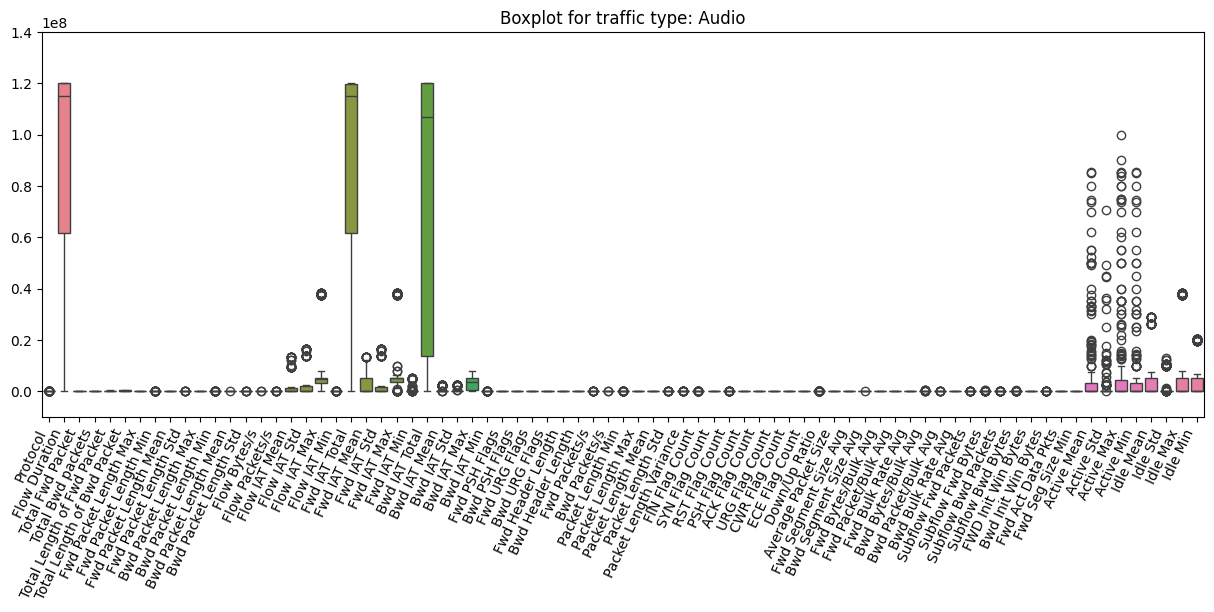

Generating boxplot ...


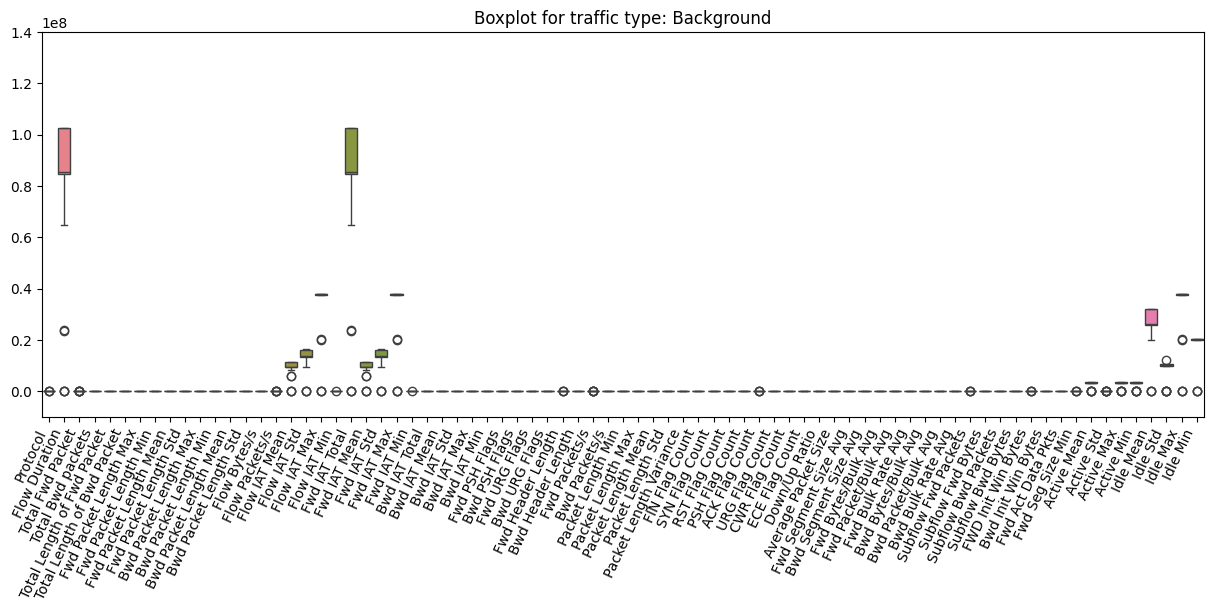

Generating boxplot ...


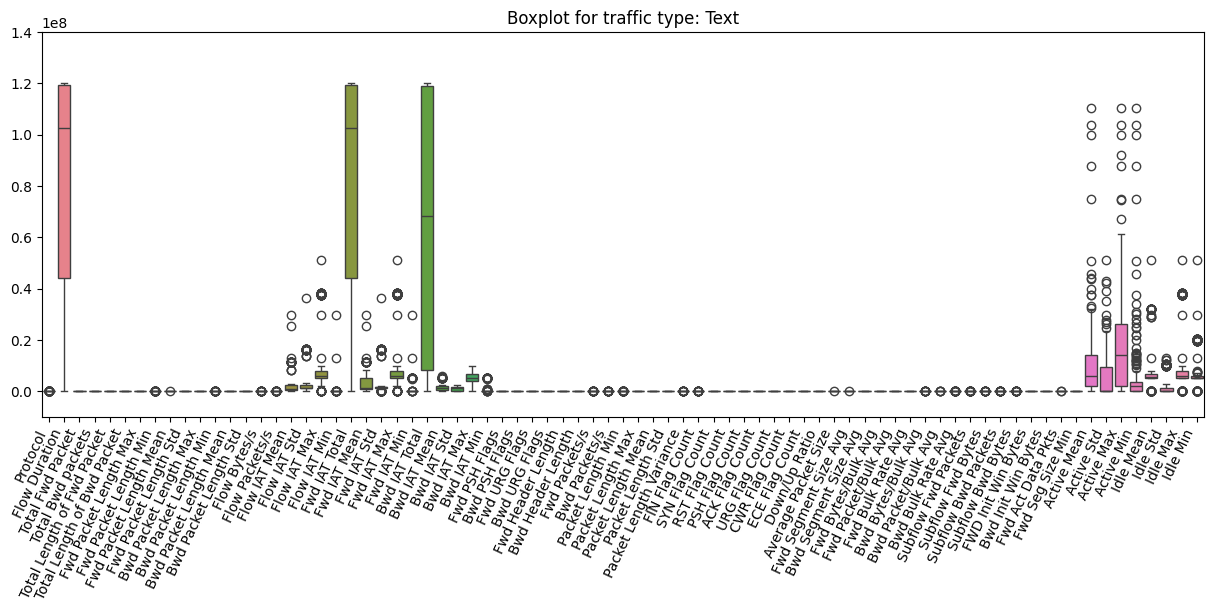

Generating boxplot ...


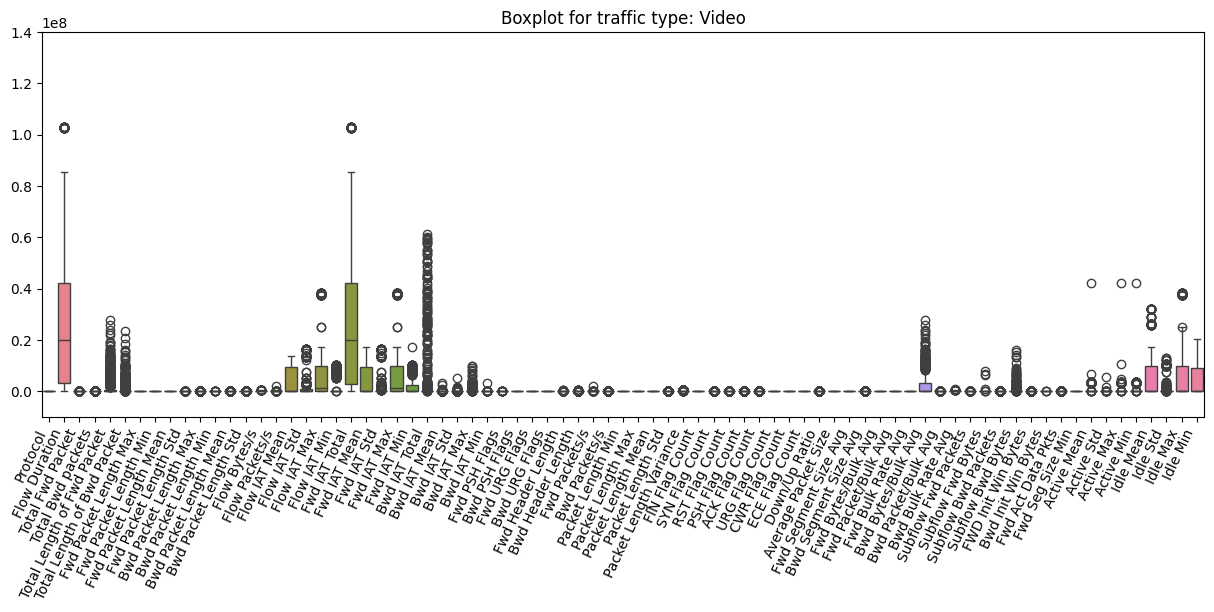

Generating boxplot ...


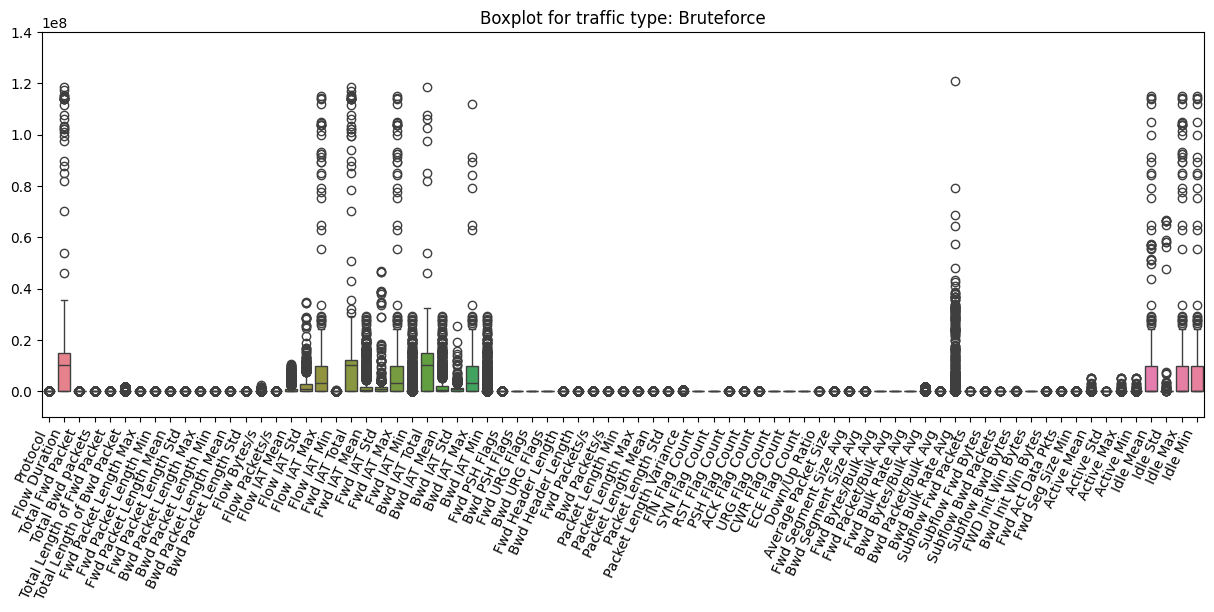

Generating boxplot ...


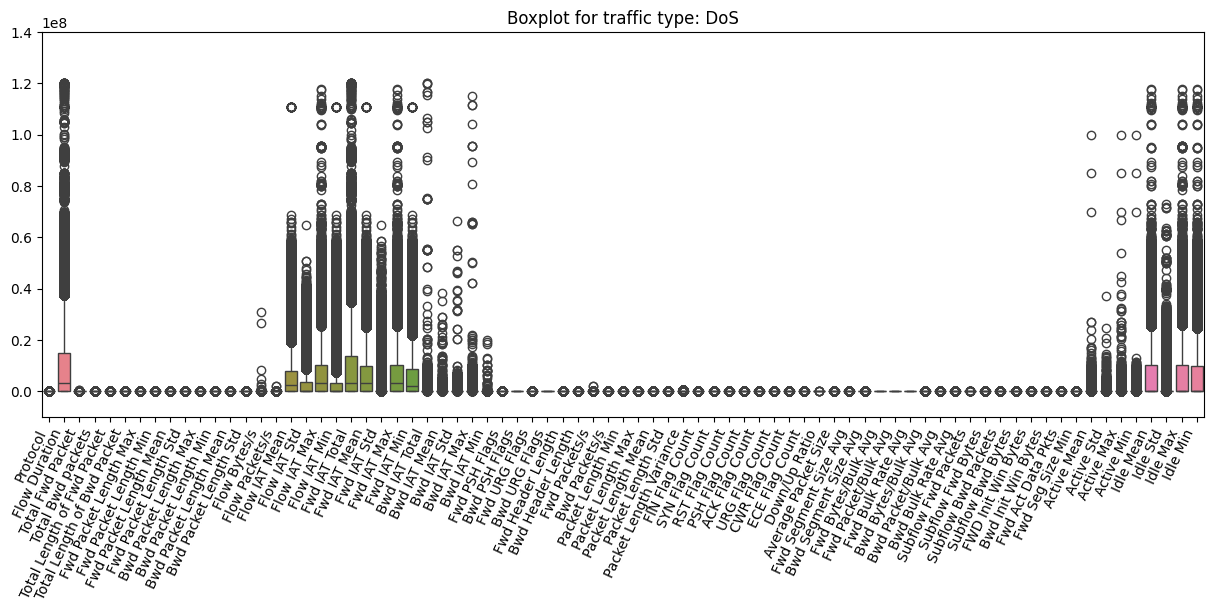

Generating boxplot ...


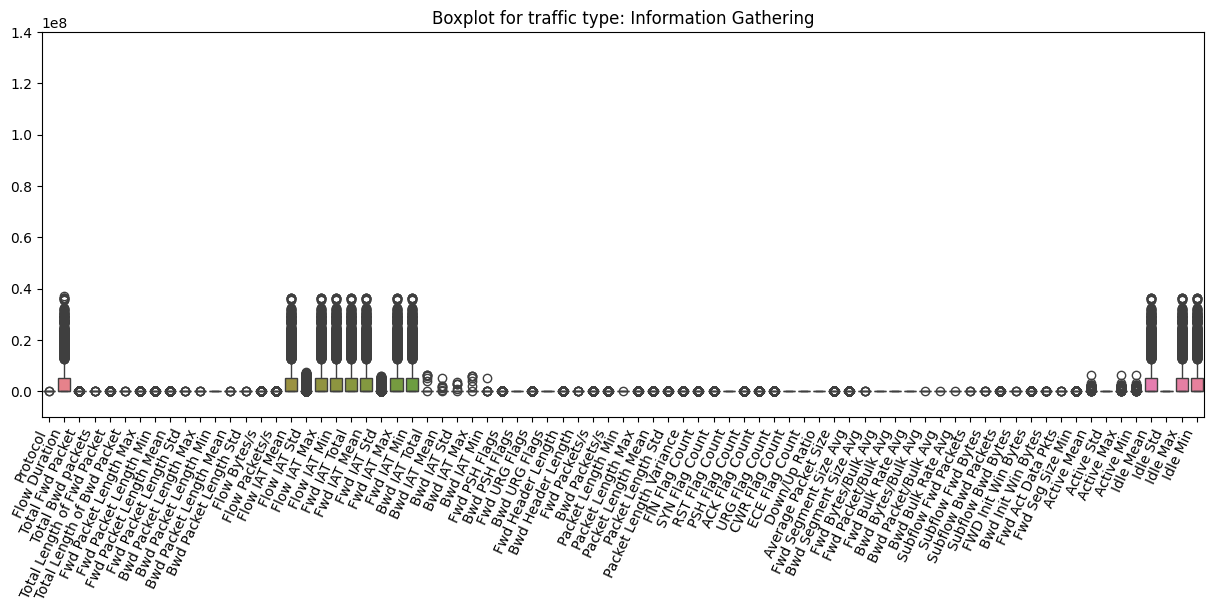

Generating boxplot ...


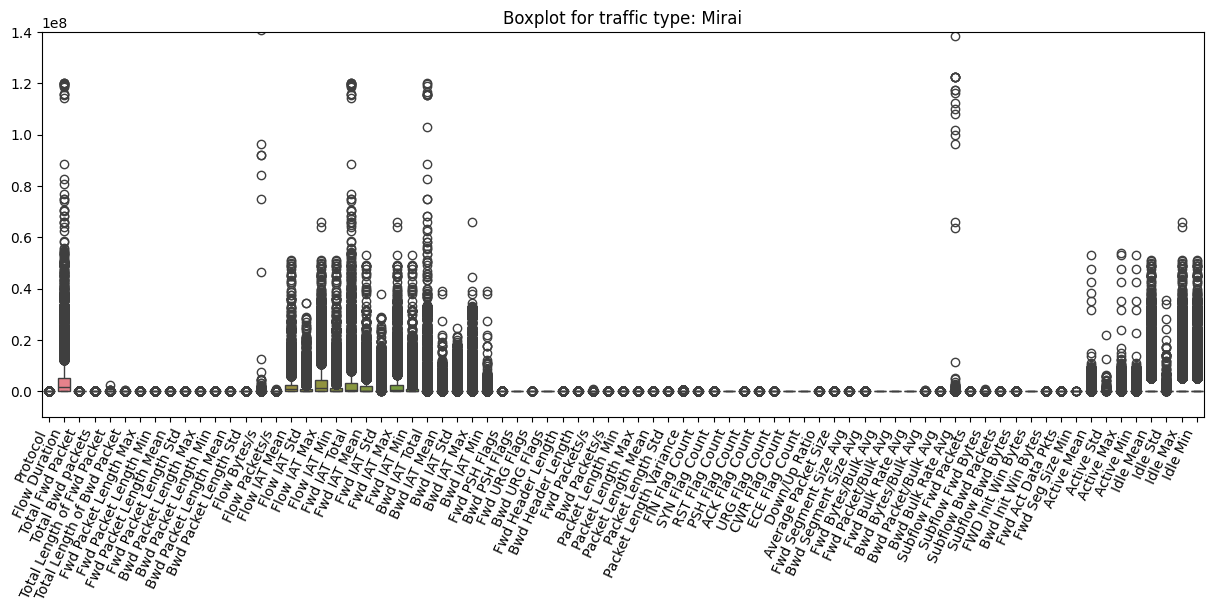

Generating boxplot ...


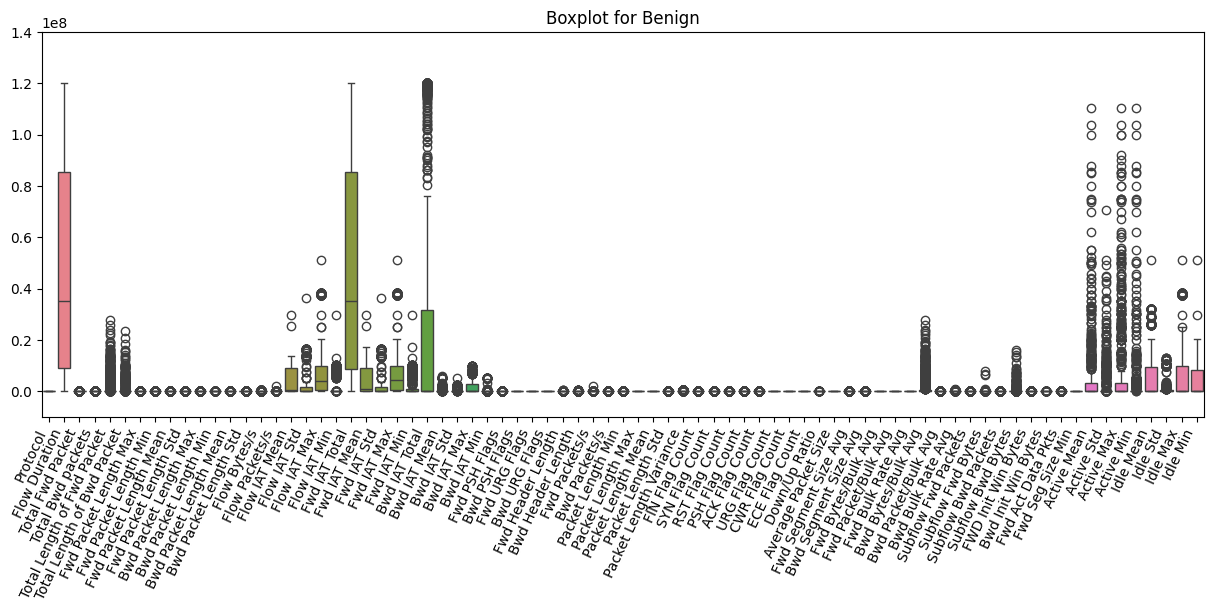

Generating boxplot ...


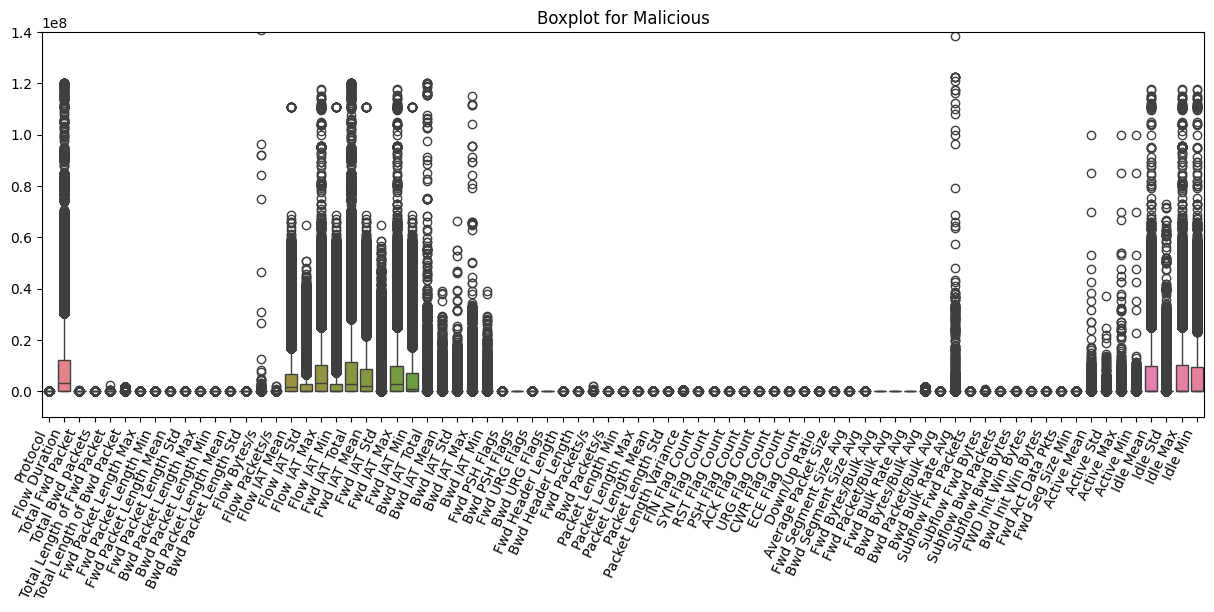

In [128]:
### Present distributions for all metrics for both Benign and Malicious labels
ylim_top = 1.4 * 1e8
ylim_bot = -0.1 * 1e8
df_benign = df[df["Label"] == "Benign"]
df_malicious = df[df["Label"] == "Malicious"]

benign_list = ["Audio", "Background", "Text", "Video"]
malicious_list = ["Bruteforce", "DoS", "Information Gathering", "Mirai"]

for ttype in benign_list:
    boxplot(df_benign[df_benign["Traffic Type"] == ttype].drop(columns=TARGET_LABELS), "Boxplot for traffic type: " + ttype, ylim_bot, ylim_top)

for ttype in malicious_list:
    boxplot(df_malicious[df_malicious["Traffic Type"] == ttype].drop(columns=TARGET_LABELS), "Boxplot for traffic type: " + ttype, ylim_bot, ylim_top)

boxplot(df_benign.drop(columns=TARGET_LABELS), "Boxplot for Benign", ylim_bot, ylim_top)
boxplot(df_malicious.drop(columns=TARGET_LABELS), "Boxplot for Malicious", ylim_bot, ylim_top)

In [167]:
# Convert all data to numerical and compute correlations
df_num = labels_to_numerical(df, LABEL_MAPPER)
df_num = ttypes_to_numerical(df_num, TYPES_MAPPER)

cor1 = correlation(df_num)
cor2, important_metrics_label, important_metrics_ttype = correlation(df_num, target=True)

22 Metrics with high correlation with Label
26 Metrics with high correlation with Traffic Type


Generating heatmap ...


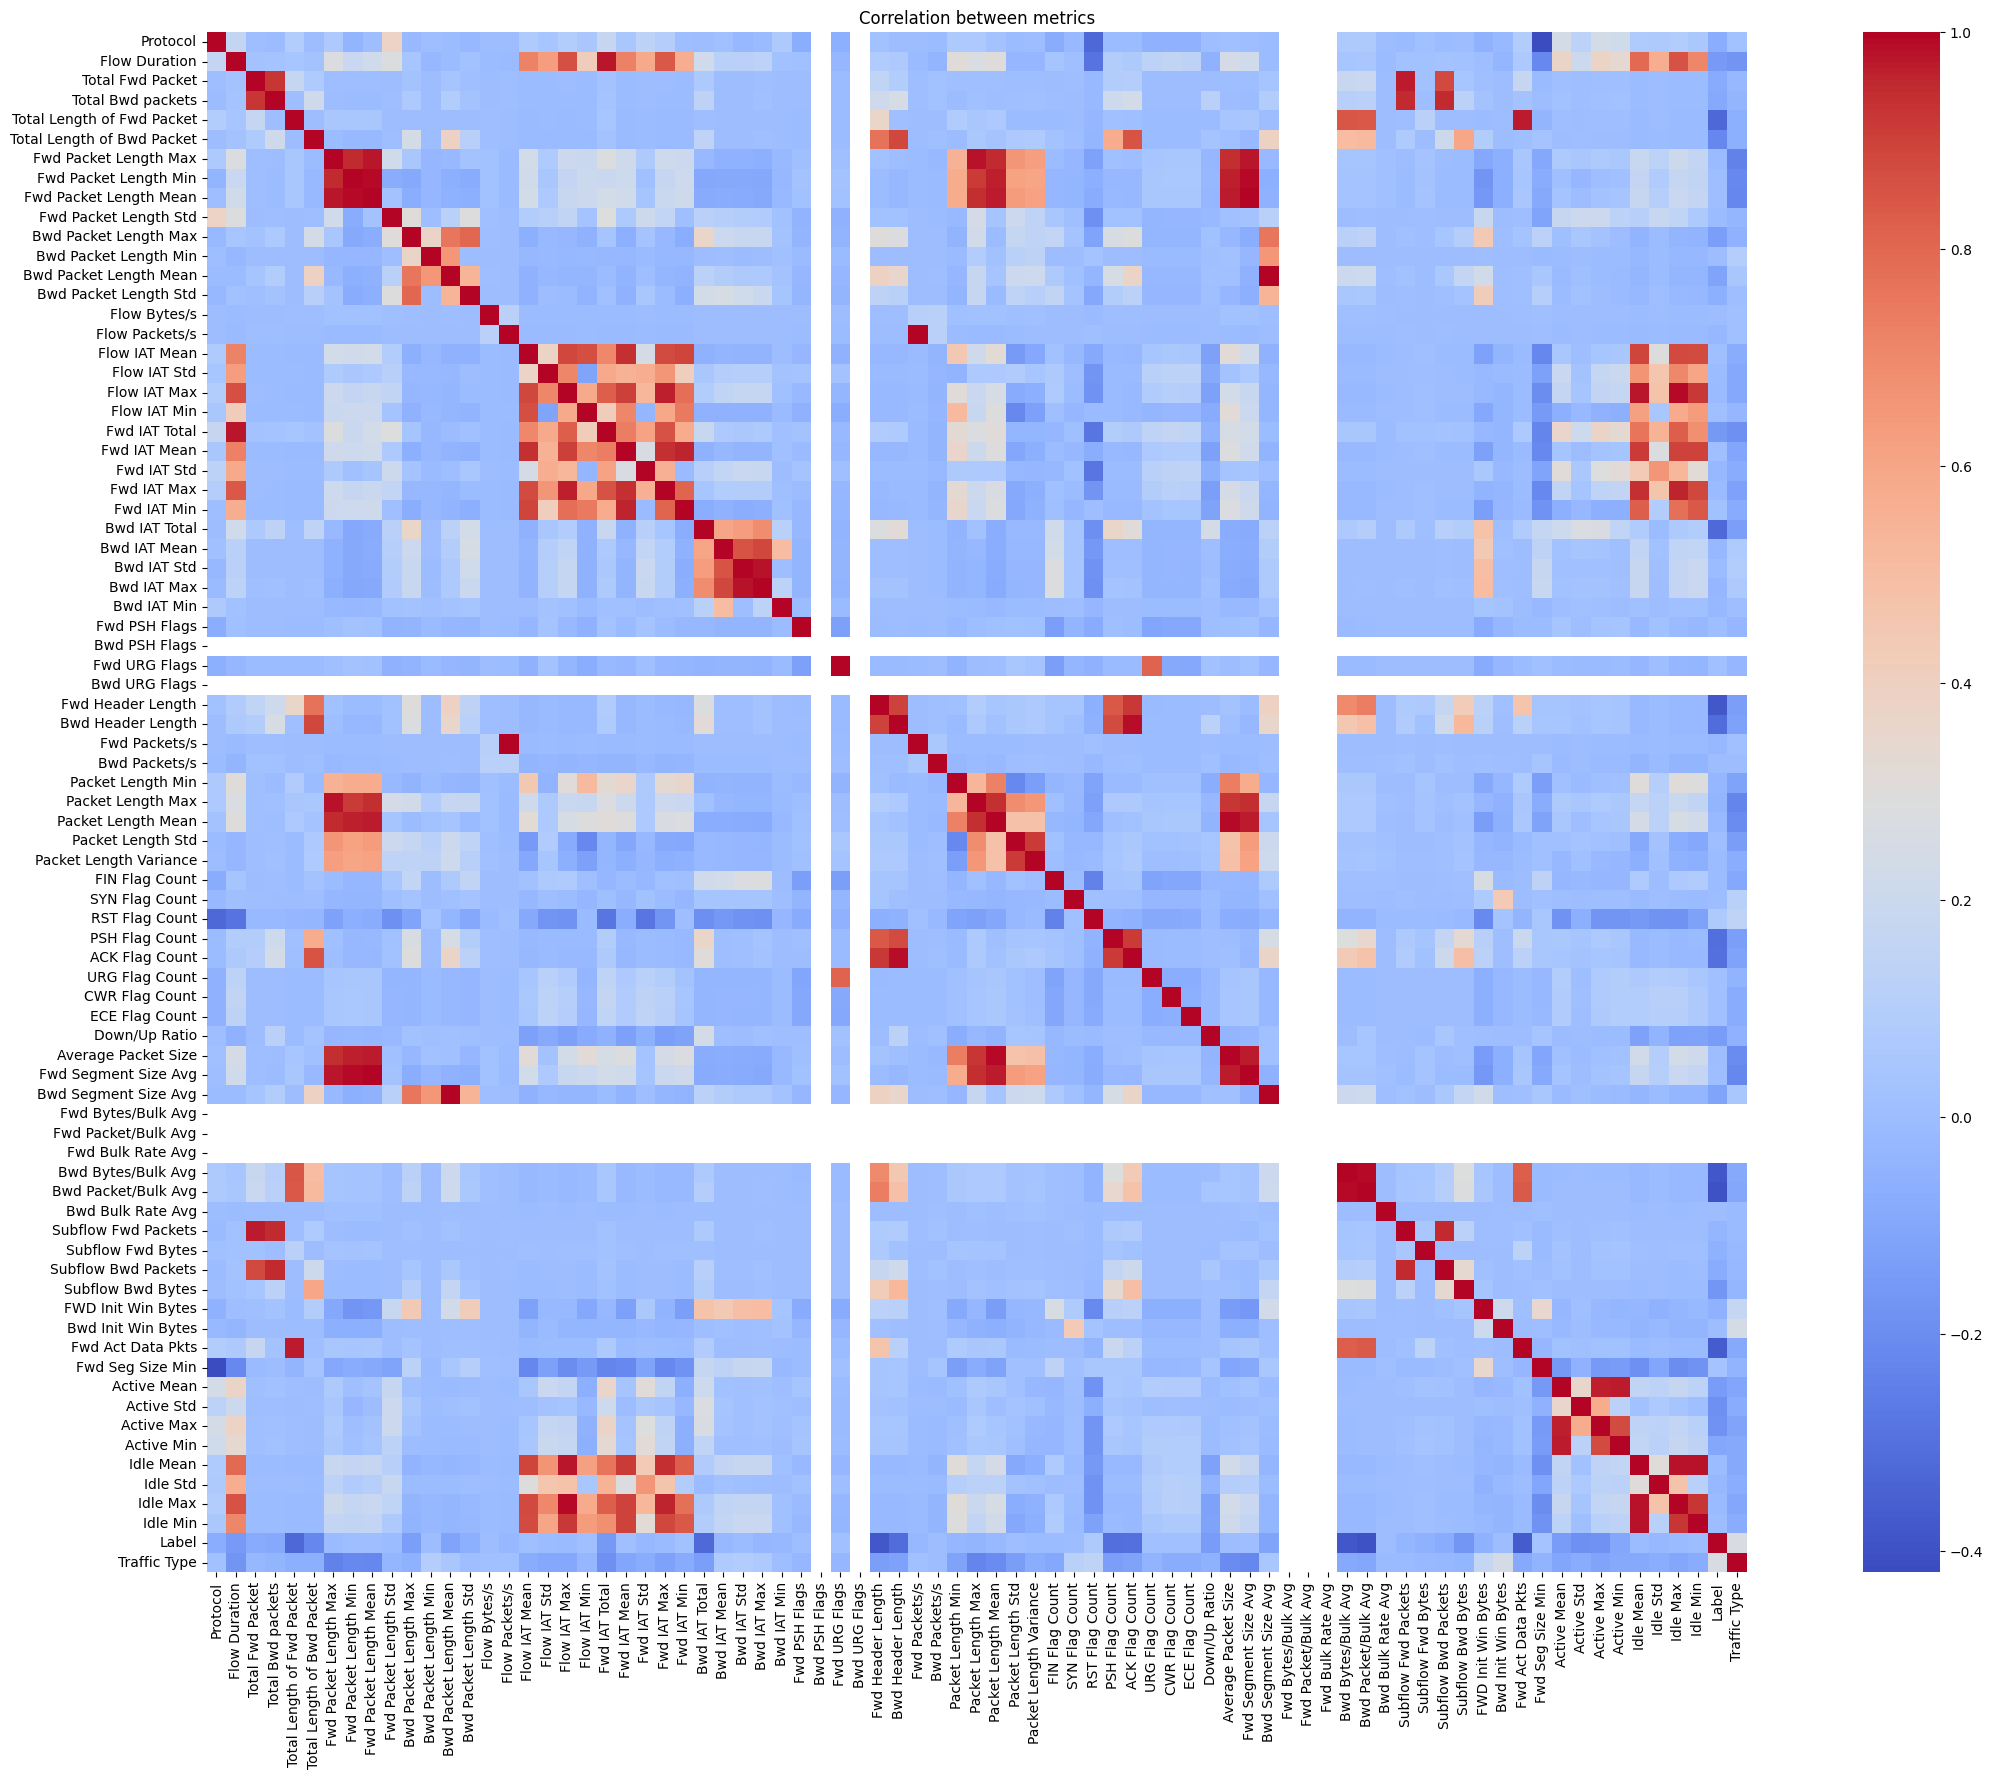

Generating heatmap ...


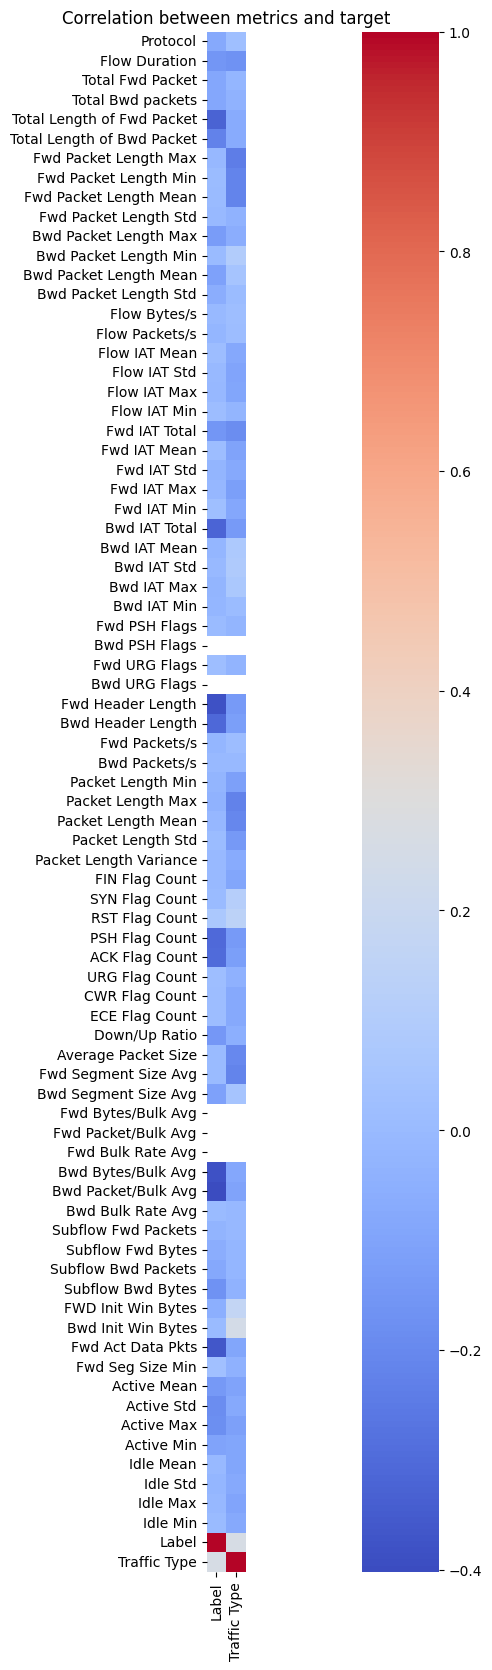

In [168]:
### Create heatmaps
heatmap(cor1, "Correlation between metrics")
heatmap(cor2, "Correlation between metrics and target")

Generating barplot ...


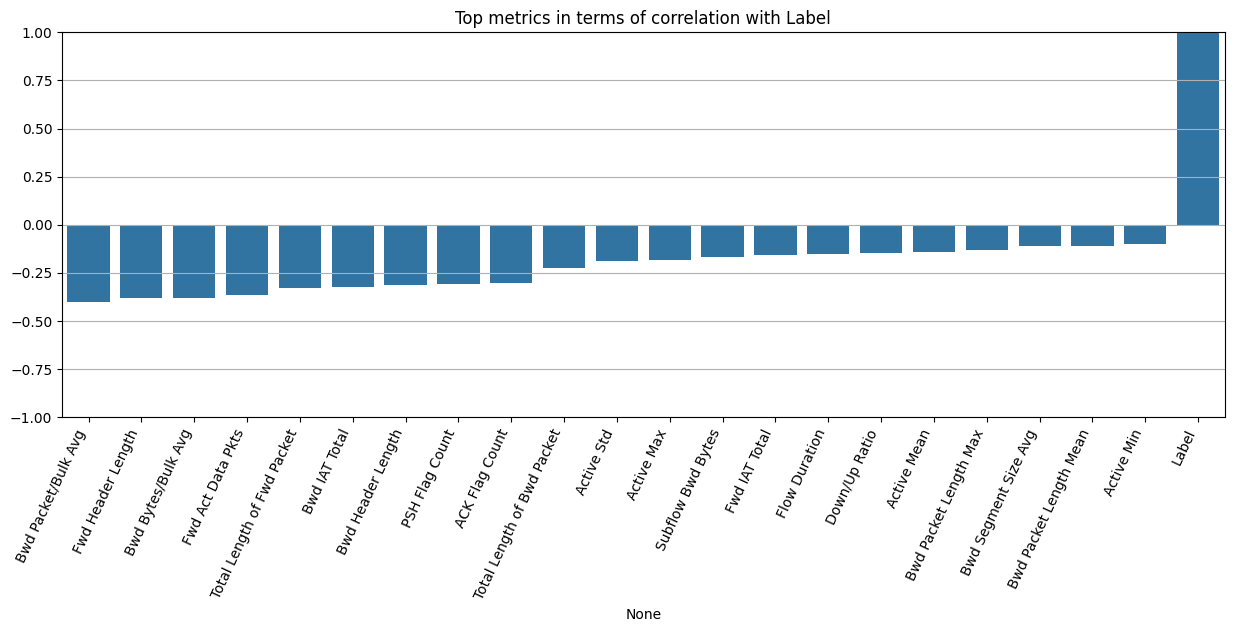

Generating barplot ...


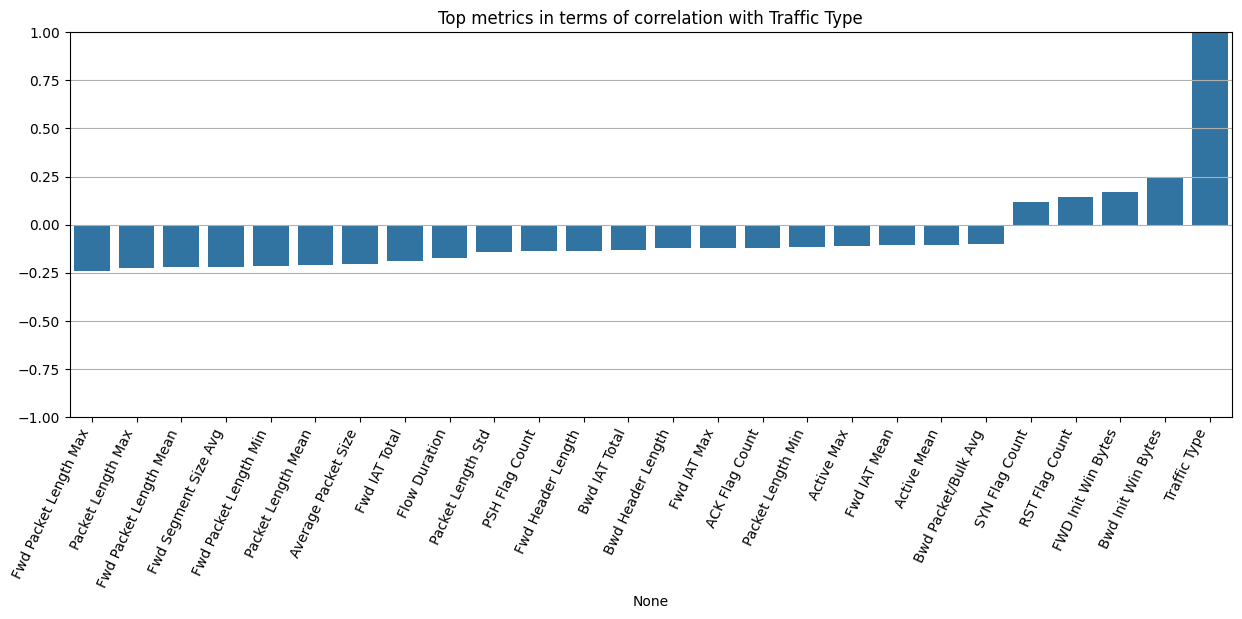

In [169]:
### Showcase top correlations
df_important_metrics_label_count = cor2.filter(items=important_metrics_label, axis="index").filter(["Label"]).sort_values(by="Label")
barplot(
    df_important_metrics_label_count.index, df_important_metrics_label_count.values.reshape(len(df_important_metrics_label_count.index)),
    "Top metrics in terms of correlation with Label"
)

df_important_metrics_ttype_count = cor2.filter(items=important_metrics_ttype, axis="index").filter(["Traffic Type"]).sort_values(by="Traffic Type")
barplot(
    df_important_metrics_ttype_count.index, df_important_metrics_ttype_count.values.reshape(len(df_important_metrics_ttype_count.index)),
    "Top metrics in terms of correlation with Traffic Type"
)

In [187]:
### DataFrames with metrics highly correlated with targets, dimension reduction and sampling
df_label = df_num[important_metrics_label]
df_ttype = df_num[important_metrics_ttype]

print("Target Label:")
df_labelDimReduction = dim_reduction(df_label.drop(columns=["Label"]), 10, "PCA")
df_label_sampled = sampling(df_labelDimReduction, 0, 0.3)
print("\n")
print("Target Traffic Type:")
df_ttypeDimReduction = dim_reduction(df_ttype.drop(columns=["Traffic Type"]), 10, "PCA")
df_ttype_sampled = sampling(df_ttypeDimReduction, 0, 0.3)


Target Label:
PCA METHOD --> Cumulative variance: 0.9850664755977583
Dataset before sampling has 456290 rows and 10 columns
Sampling ...
Dataset after sampling has 136887 rows and 10 columns


Target Traffic Type:
PCA METHOD --> Cumulative variance: 0.9583892485097205
Dataset before sampling has 456290 rows and 10 columns
Sampling ...
Dataset after sampling has 136887 rows and 10 columns
